# Tableau Data Story 📘 embed 

Here is a the quick data story the following Analytics code helps tell 📘

----

<iframe src="https://public.tableau.com/views/tiktok_eda/Story1?:showVizHome=no&:embed=true"
        width="1016" height="991" frameborder="0"></iframe>


# imports 

In [108]:
# data transforms 
import pandas as pd 
import numpy as np

# data viz 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 
import plotly.figure_factory as ff

# ml preprocessing 
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample

# ml modeling 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (
    classification_report, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier, DMatrix, cv, train 

# statistics 
from scipy import stats

# save model
import joblib 

In [2]:
tiktok_df = pd.read_csv('tiktok_dataset.csv')
tiktok_df.head()

# claim_status    video_id  video_duration_sec  \
0  1        claim  7017666017                  59   
1  2        claim  4014381136                  32   
2  3        claim  9859838091                  31   
3  4        claim  1866847991                  25   
4  5        claim  7105231098                  19   

                            video_transcription_text verified_status  \
0  someone shared with me that drone deliveries a...    not verified   
1  someone shared with me that there are more mic...    not verified   
2  someone shared with me that american industria...    not verified   
3  someone shared with me that the metro of st. p...    not verified   
4  someone shared with me that the number of busi...    not verified   

  author_ban_status  video_view_count  video_like_count  video_share_count  \
0      under review          343296.0           19425.0              241.0   
1            active          140877.0           77355.0            19034.0   
2            active          902185.0           97690.0             2858.0   
3            active          437506.0          239954.0            34812.0   
4            active           56167.0           34987.0             4110.0   

   video_download_count  video_comment_count  
0                   1.0                  0.0  
1                1161.0                684.0  
2                 833.0                329.0  
3                1234.0                584.0  
4                 547.0                152.0

# Data Exploration


## basic stats

In [49]:
tiktok_df.size 

290730

In [4]:
tiktok_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


In [5]:
tiktok_df.describe()

#      video_id  video_duration_sec  video_view_count  \
count  19382.000000  1.938200e+04        19382.000000      19084.000000   
mean    9691.500000  5.627454e+09           32.421732     254708.558688   
std     5595.245794  2.536440e+09           16.229967     322893.280814   
min        1.000000  1.234959e+09            5.000000         20.000000   
25%     4846.250000  3.430417e+09           18.000000       4942.500000   
50%     9691.500000  5.618664e+09           32.000000       9954.500000   
75%    14536.750000  7.843960e+09           47.000000     504327.000000   
max    19382.000000  9.999873e+09           60.000000     999817.000000   

       video_like_count  video_share_count  video_download_count  \
count      19084.000000       19084.000000          19084.000000   
mean       84304.636030       16735.248323           1049.429627   
std       133420.546814       32036.174350           2004.299894   
min            0.000000           0.000000              0.000000   
25%          810.750000         115.000000              7.000000   
50%         3403.500000         717.000000             46.000000   
75%       125020.000000       18222.000000           1156.250000   
max       657830.000000      256130.000000          14994.000000   

       video_comment_count  
count         19084.000000  
mean            349.312146  
std             799.638865  
min               0.000000  
25%               1.000000  
50%               9.000000  
75%             292.000000  
max            9599.000000

In [6]:
tiktok_df.shape

(19382, 12)

### understand variables

In [4]:
# What is the average view count of videos with "claim" status?
claims = tiktok_df[tiktok_df['claim_status'] == 'claim']
print('Mean view count claims:', f"{claims['video_view_count'].mean():,.2f}")
print('Median view count claims:', f"{claims['video_view_count'].median():,.2f}")

Mean view count claims: 501,029.45
Median view count claims: 501,555.00


In [6]:
# What is the average view count of videos with "opinion" status?
opinions = tiktok_df[tiktok_df['claim_status'] == 'opinion']
print('Mean view count opinions:', f"{opinions['video_view_count'].mean():,.2f}")
print('Median view count opinions:', f"{opinions['video_view_count'].median():,.2f}")

Mean view count opinions: 4,956.43
Median view count opinions: 4,953.00


In [11]:
(
    tiktok_df.groupby(['claim_status', 'author_ban_status'])
    .count()[['#']].rename(columns={'#': 'total'})
    .assign(total=lambda df: df['total'].apply(lambda x: f"{x:,}"))
)

total
claim_status author_ban_status       
claim        active             6,566
             banned             1,439
             under review       1,603
opinion      active             8,817
             banned               196
             under review         463

Insights from prior cell 
- The proportion of banned and under_review groups in author_ban_status is much higher for video's that make a claim rather than videos that just have an opinion.   

In [19]:
# investigating author ban status 
tiktok_df.groupby(['author_ban_status']).agg(
    {
        'video_view_count': ['count', 'mean', 'median'],
        'video_like_count': ['count', 'mean', 'median'],
        'video_share_count': ['count', 'mean', 'median']
    }
).map(lambda x: f"{x:,.0f}")

video_view_count                   video_like_count  \
                             count     mean   median            count   
author_ban_status                                                       
active                      15,383  215,927    8,616           15,383   
banned                       1,635  445,845  448,201            1,635   
under review                 2,066  392,205  365,246            2,066   

                                    video_share_count                  
                      mean   median             count    mean  median  
author_ban_status                                                      
active              71,037    2,222            15,383  14,111     437  
banned             153,017  105,573             1,635  29,999  14,468  
under review       128,718   71,204             2,066  25,775   9,444

Insights from prior cell
- banned authors have 33x more video shares than active authors
- banned and under_review authors get much higher views, likes and shares
- the big differences in means and medians indicate heavy skew (there are some videos that get exceptionally high engagement that skew the mean)

### calculate proportions

In [31]:
# Create 3 new columns to calculate proportion 
tiktok_df['likes_per_view'] = tiktok_df['video_like_count'] / tiktok_df['video_view_count']
tiktok_df['comments_per_view'] = tiktok_df['video_comment_count'] / tiktok_df['video_view_count']
tiktok_df['shares_per_view'] = tiktok_df['video_share_count'] / tiktok_df['video_view_count']


# Scale proportions to 'per 1,000'
proportion = 1000
tiktok_df['likes_per_view'] *= proportion
tiktok_df['comments_per_view'] *= proportion
tiktok_df['shares_per_view'] *= proportion

# Group and calculate just scaled medians
tiktok_df.groupby(['claim_status', 'author_ban_status']).agg(
    {
        'likes_per_view': ['count', ('median_proportion', lambda x: f"{x.median():,.2f} per {proportion:,} views")],
        'comments_per_view': ['count', ('median_proportion', lambda x: f"{x.median():,.2f} per {proportion:,} views")],
        'shares_per_view': ['count', ('median_proportion', lambda x: f"{x.median():,.2f} per {proportion:,} views")]
    }
)


likes_per_view                          \
                                        count       median_proportion   
claim_status author_ban_status                                          
claim        active                      6566  326.54 per 1,000 views   
             banned                      1439  358.91 per 1,000 views   
             under review                1603  320.87 per 1,000 views   
opinion      active                      8817  218.33 per 1,000 views   
             banned                       196  198.48 per 1,000 views   
             under review                 463  228.05 per 1,000 views   

                               comments_per_view                        \
                                           count     median_proportion   
claim_status author_ban_status                                           
claim        active                         6566  0.78 per 1,000 views   
             banned                         1439  0.75 per 1,000 views   
             under review                   1603  0.79 per 1,000 views   
opinion      active                         8817  0.25 per 1,000 views   
             banned                          196  0.19 per 1,000 views   
             under review                    463  0.29 per 1,000 views   

                               shares_per_view                         
                                         count      median_proportion  
claim_status author_ban_status                                         
claim        active                       6566  49.28 per 1,000 views  
             banned                       1439  51.61 per 1,000 views  
             under review                 1603  49.97 per 1,000 views  
opinion      active                       8817  32.40 per 1,000 views  
             banned                        196  30.73 per 1,000 views  
             under review                  463  35.03 per 1,000 views

Insights from prior cells
- When video's do get viewed the proportion of likes, comments, and shares is similar across authors who are active, banned, or under_review
- The proportion of likes, comments, and shares is still higher for videos that make a claim. 
- Of the 19,382 samples in this dataset, just under 50% are claims&mdash;9,608 of them.  
- Engagement level is strongly correlated with claim status. This will be a focus of Hypothesis Testing.
- Videos with banned authors have significantly higher engagement than videos with active authors. Videos with authors under_review fall inbetween.

## drop missing vals

In [7]:
tiktok_df.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In [8]:
tiktok_df.dropna(axis=0, inplace=True)
tiktok_df.isna().sum()

#                           0
claim_status                0
video_id                    0
video_duration_sec          0
video_transcription_text    0
verified_status             0
author_ban_status           0
video_view_count            0
video_like_count            0
video_share_count           0
video_download_count        0
video_comment_count         0
dtype: int64

## value counts, proportion, mean

In [9]:
tiktok_df['verified_status'].value_counts()

verified_status
not verified    17884
verified         1200
Name: count, dtype: int64

In [10]:
# the proportion of verified and unverified users 
tiktok_df['verified_status'].value_counts(normalize=True)

verified_status
not verified    0.93712
verified        0.06288
Name: proportion, dtype: float64

In [11]:
# the mean views for verified and unverified tiktoks 
tiktok_df.groupby('verified_status')['video_view_count'].mean() 

verified_status
not verified    265663.785339
verified         91439.164167
Name: video_view_count, dtype: float64

## outliers

### `video_comment_count`

In [12]:
# Create the box plot
fig = px.box(tiktok_df, 
             x='video_comment_count', 
             title='Boxplot to detect outliers for video_comment_count')

# Show the plot
fig.show()

In [13]:
q25 = tiktok_df['video_comment_count'].quantile(.25)
q75 = tiktok_df['video_comment_count'].quantile(.75)

iqr = q75 - q25 

upper_limit = q75 + 1.5 * iqr

tiktok_df.loc[tiktok_df['video_comment_count'] > upper_limit, 'video_comment_count'] = upper_limit

q25, q75, iqr, upper_limit 

(np.float64(1.0), np.float64(292.0), np.float64(291.0), np.float64(728.5))

In [14]:
# Create the box plot
fig = px.box(tiktok_df, 
             x='video_comment_count', 
             title='Boxplot to detect outliers for video_comment_count')

# Show the plot
fig.show()

### `video_like_count`

In [15]:
# Create the box plot
fig = px.box(tiktok_df, 
             x='video_like_count', 
             title='Boxplot to detect outliers for video_like_count')

# Show the plot
fig.show()

In [16]:
q25 = tiktok_df['video_like_count'].quantile(.25)
q75 = tiktok_df['video_like_count'].quantile(.75)

iqr = q75 - q25 

upper_limit = q75 + 1.5 * iqr 

tiktok_df.loc[tiktok_df['video_like_count'] > upper_limit, 'video_like_count'] = upper_limit

q25, q75, iqr, upper_limit

(np.float64(810.75),
 np.float64(125020.0),
 np.float64(124209.25),
 np.float64(311333.875))

In [17]:
# Create the box plot after reassigning 
fig = px.box(tiktok_df, 
             x='video_like_count', 
             title='Boxplot to detect outliers for video_like_count')

# Show the plot
fig.show()

## resampling 

In [18]:
tiktok_df['verified_status'].value_counts()

verified_status
not verified    17884
verified         1200
Name: count, dtype: int64

In [19]:
majority = tiktok_df[tiktok_df['verified_status'] == 'not verified']
majority.shape 

(17884, 12)

In [20]:

minority = tiktok_df[tiktok_df['verified_status'] == 'verified']
minority.shape 

(1200, 12)

In [21]:

upsample = resample(minority, replace=True, n_samples=len(majority), random_state=42)

upsampled_df = pd.concat([majority, upsample]).reset_index(drop=True)

upsampled_df['verified_status'].value_counts() 

verified_status
not verified    17884
verified        17884
Name: count, dtype: int64

## correlation 

In [22]:
upsampled_df.corr(numeric_only=True) 

#  video_id  video_duration_sec  \
#                     1.000000 -0.001369           -0.011800   
video_id             -0.001369  1.000000            0.013938   
video_duration_sec   -0.011800  0.013938            1.000000   
video_view_count     -0.698969  0.001607            0.013892   
video_like_count     -0.626105  0.004534            0.004028   
video_share_count    -0.503634  0.009136            0.001944   
video_download_count -0.489758  0.006814            0.006930   
video_comment_count  -0.610763  0.010564           -0.000080   

                      video_view_count  video_like_count  video_share_count  \
#                            -0.698969         -0.626105          -0.503634   
video_id                      0.001607          0.004534           0.009136   
video_duration_sec            0.013892          0.004028           0.001944   
video_view_count              1.000000          0.855343           0.710466   
video_like_count              0.855343          1.000000           0.832361   
video_share_count             0.710466          0.832361           1.000000   
video_download_count          0.691557          0.806369           0.709738   
video_comment_count           0.747564          0.816416           0.671601   

                      video_download_count  video_comment_count  
#                                -0.489758            -0.610763  
video_id                          0.006814             0.010564  
video_duration_sec                0.006930            -0.000080  
video_view_count                  0.691557             0.747564  
video_like_count                  0.806369             0.816416  
video_share_count                 0.709738             0.671601  
video_download_count              1.000000             0.794524  
video_comment_count               0.794524             1.000000

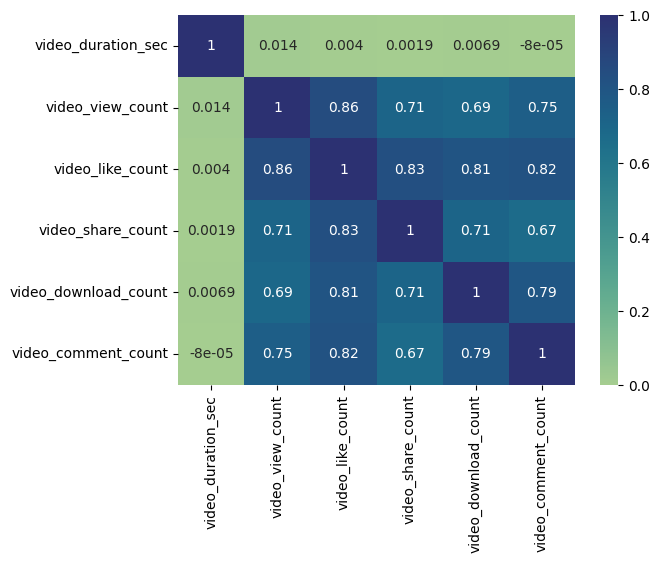

In [23]:
sns.heatmap(
    upsampled_df[[
        "video_duration_sec",
        #"claim_status", 
        #"author_ban_status", 
        "video_view_count",
        "video_like_count", 
        "video_share_count", 
        "video_download_count", 
        "video_comment_count"]].corr(),
    annot=True, 
    cmap='crest'
)

plt.show() 

# Hypothesis testing:

In [46]:
# set alpha value 
alpha = 0.05 



## `video_view_count` of `verified_status`

Hypotheses: 
1. null hypothesis = there is NOT a statistically significant difference of video_view_count between the 2 groups of verified users
2. alt hypothesis  = there is a statistically significant different video_view_count between the 2 groups of verified users 

In [24]:
not_verified = tiktok_df[tiktok_df['verified_status'] == 'not verified']['video_view_count']
verified = tiktok_df[tiktok_df['verified_status'] == 'verified']['video_view_count']

In [38]:
tiktok_df['verified_status'].value_counts(normalize=True)

verified_status
not verified    0.936023
verified        0.063977
Name: proportion, dtype: float64

In [25]:
stats.ttest_ind(a=verified, b=not_verified, equal_var=False)

TtestResult(statistic=np.float64(-25.499441780633777), pvalue=np.float64(2.6088823687177823e-120), df=np.float64(1571.163074387424))

We reject the null hypothesis. This could mean that there might be a fundamental difference in behavior between verified and non-verified users.   

## `video_view_count` of `claim_status`

1. null hypothesis = there is NOT a significantly different video_view_count between videos that are an opinion vs videos that make a claim (i.e. the claim_status groups)
2. alt hypothesis = there is a significantly different video_view_count between videos that are an opinion vs videos that make a claim (i.e. the claim_status groups)

In [39]:
tiktok_df['claim_status'].value_counts(normalize=True)

claim_status
claim      0.503458
opinion    0.496542
Name: proportion, dtype: float64

In [35]:
# Format to avoid scientific notation and add commas
tiktok_df.groupby(['claim_status']).sum()['video_view_count'].apply(lambda x: f"{x:,.0f}")


claim_status
claim      4,813,890,982
opinion       46,967,152
Name: video_view_count, dtype: object

In [36]:
claim_views = tiktok_df[tiktok_df['claim_status'] == 'claim']['video_view_count'] 
opinion_views = tiktok_df[tiktok_df['claim_status'] == 'opinion']['video_view_count'] 

In [41]:
stats.ttest_ind(a=opinion_views, b=claim_views, equal_var=True)

TtestResult(statistic=np.float64(-165.73837511718082), pvalue=np.float64(0.0), df=np.float64(19082.0))

In [43]:
claim_ht = stats.ttest_ind(a=claim_views, b=opinion_views, equal_var=True)
claim_ht

TtestResult(statistic=np.float64(165.73837511718082), pvalue=np.float64(0.0), df=np.float64(19082.0))

In [48]:
claim_ht_pval = claim_ht[1] 
claim_ht_pval < alpha 

np.True_

Since the claim hypothesis_test p-value is less than alpha we reject the null hypothesis 

# Data Visualizations 

#### video_duration_sec

In [55]:
fig = px.box(tiktok_df, x='video_duration_sec', title='video_duration_sec', width=700, height=300)
fig.show() 

In [54]:
# Create the histogram
fig = px.histogram(
    tiktok_df,
    x='video_duration_sec',
    nbins=12,  # Bins from 0 to 60 in steps of 5
    title='Video duration histogram',
    width=700, height=500
)

# Update bar appearance
fig.update_traces(
    marker=dict(
        line=dict(width=1, color='black')  # Add a black outline to each bar
    ),
    opacity=0.9  # Slight transparency for better aesthetics
)

# Add spacing between bars
fig.update_layout(
    bargap=0.2  # Adjust space between bars (value between 0 and 1)
)

fig.update_xaxes(dtick=5)  # Ensure x-axis ticks align with the bin ranges
fig.show()


#### video_view_count

In [56]:
# Create the box plot
fig = px.box(
    tiktok_df,
    x='video_view_count',
    title='video_view_count',
    width=700,
    height=300
)

fig.show()

In [57]:
# Create the histogram
fig = px.histogram(
    tiktok_df,
    x='video_view_count',
    nbins=10,  # Corresponds to bins from 0 to 1,000,000 in steps of 100,000
    title='Video view count histogram',
    width=700,
    height=500
)

# Update bar appearance
fig.update_traces(
    marker=dict(
        line=dict(width=1, color='black')  # Add a black outline to each bar
    ),
    opacity=0.9  # Slight transparency for better aesthetics
)

# Add spacing between bars
fig.update_layout(
    bargap=0.2  # Adjust space between bars (value between 0 and 1)
)

fig.update_xaxes(dtick=100000)  # Ensure x-axis ticks align with the bin ranges
fig.show()

#### video_like_count

In [58]:
# Create the box plot
fig = px.box(
    tiktok_df,
    x='video_like_count',
    title='video_like_count',
    width=700,
    height=300
)

fig.show()

In [59]:
# Create the histogram
fig = px.histogram(
    tiktok_df,
    x='video_like_count',
    nbins=7,  # Corresponds to bins from 0 to 700,000 in steps of 100,000
    title='Video like count histogram',
    width=700,
    height=500
)

# Update bar appearance
fig.update_traces(
    marker=dict(
        line=dict(width=1, color='black')  # Add a black outline to each bar
    ),
    opacity=0.9  # Slight transparency for better aesthetics
)

# Add spacing between bars
fig.update_layout(
    bargap=0.2  # Adjust space between bars (value between 0 and 1)
)

# Set custom x-axis tick labels
fig.update_xaxes(
    tickvals=list(range(0, 7 * 10**5 + 1, 10**5)),
    ticktext=['0'] + [f'{i}k' for i in range(100, 701, 100)]
)

fig.show()

#### video_comment_count

In [60]:
# Create the box plot
fig = px.box(
    tiktok_df,
    x='video_comment_count',
    title='video_comment_count',
    width=700,
    height=300
)

fig.show()


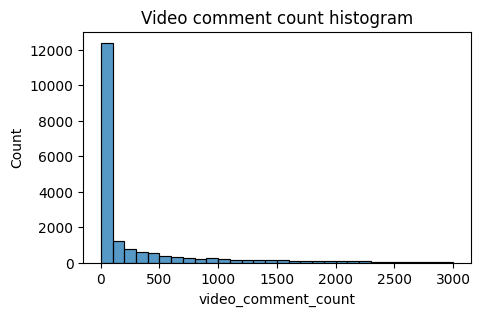

In [64]:
plt.figure(figsize=(5,3))
sns.histplot(tiktok_df['video_comment_count'], bins=range(0,(3001),100))
plt.title('Video comment count histogram');

#### video_share_count

In [65]:
# Create the box plot
fig = px.box(
    tiktok_df,
    x='video_share_count',
    title='video_share_count',
    width=700,
    height=300
)

fig.show()

In [66]:
# Create the histogram
fig = px.histogram(
    tiktok_df,
    x='video_share_count',
    nbins=27,  # Corresponds to bins from 0 to 270,000 in steps of 10,000
    title='Video share count histogram',
    width=700,
    height=500
)

# Update bar appearance
fig.update_traces(
    marker=dict(
        line=dict(width=1, color='black')  # Add a black outline to each bar
    ),
    opacity=0.9  # Slight transparency for better aesthetics
)

# Add spacing between bars
fig.update_layout(
    bargap=0.2  # Adjust space between bars (value between 0 and 1)
)

# Set x-axis ticks for better readability
fig.update_xaxes(dtick=10000)

fig.show()


#### video_download_count

In [67]:
# Create the box plot
fig = px.box(
    tiktok_df,
    x='video_download_count',
    title='video_download_count',
    width=700,
    height=300
)

fig.show()

In [68]:
# Create the histogram
fig = px.histogram(
    tiktok_df,
    x='video_download_count',
    nbins=30,  # Corresponds to bins from 0 to 15,000 in steps of 500
    title='Video download count histogram',
    width=700,
    height=500
)

# Update bar appearance
fig.update_traces(
    marker=dict(
        line=dict(width=1, color='black')  # Add a black outline to each bar
    ),
    opacity=0.9  # Slight transparency for better aesthetics
)

# Add spacing between bars
fig.update_layout(
    bargap=0.2  # Adjust space between bars (value between 0 and 1)
)

# Set x-axis ticks for better readability
fig.update_xaxes(dtick=500)

fig.show()


#### claim_status x verified_status

In [69]:
# Create the histogram
fig = px.histogram(
    tiktok_df,
    x='claim_status',
    color='verified_status',  # Use hue equivalent
    barmode='group',  # Corresponds to 'dodge' in Seaborn
    title='Claims by verification status histogram',
    width=700,
    height=500
)

# Adjust bar spacing for a grouped view
fig.update_traces(
    marker=dict(
        line=dict(width=1, color='black')  # Add a black outline to each bar
    ),
    opacity=0.9  # Slight transparency for better aesthetics
)

fig.update_layout(
    bargap=0.1  # Reduce space between bar groups
)

fig.show()

#### claim_status x author_ban_status

In [70]:
# Create the histogram
fig = px.histogram(
    tiktok_df,
    x='claim_status',
    color='author_ban_status',  # Use hue equivalent
    barmode='group',  # Corresponds to 'dodge' in Seaborn
    title='Claim status by author ban status - counts',
    width=700,
    height=500,
    color_discrete_map={'active': 'green', 'under review': 'orange', 'banned': 'red'}  # Custom color palette
)

# Adjust bar transparency and spacing for a grouped view
fig.update_traces(
    opacity=0.5,  # Match alpha transparency
    marker=dict(
        line=dict(width=1, color='black')  # Add a black outline to each bar
    )
)

fig.update_layout(
    bargap=0.1  # Reduce space between bar groups
)

fig.show()


#### author_ban_status medians

In [72]:
# Prepare the grouped data for plotting
ban_status_counts = (tiktok_df
                     .groupby(['author_ban_status'])
                     .median(numeric_only=True)
                     .reset_index())

# Create the bar plot
fig = px.bar(
    ban_status_counts,
    x='author_ban_status',
    y='video_view_count',
    title='Median view count by ban status',
    width=700,
    height=500,
    color='author_ban_status',
    color_discrete_map={'active': 'green', 'under review': 'orange', 'banned': 'red'}  # Custom color palette
)

# Adjust bar transparency for matching Seaborn's alpha
fig.update_traces(
    opacity=0.5,
    marker=dict(
        line=dict(width=1, color='black')  # Add a black outline to each bar
    )
)

fig.show()


#### video views by claim status piechart

In [74]:
# Prepare data for the pie chart
views_by_claim_status = tiktok_df.groupby('claim_status')['video_view_count'].sum().reset_index()

# Create the pie chart
fig = px.pie(
    views_by_claim_status,
    values='video_view_count',
    names='claim_status',
    title='Total views by video claim status',
    width=500,
    height=500
)

fig.show()

## Heavily skewed outlier

In [ ]:
count_cols = ['video_view_count',
              'video_like_count',
              'video_share_count',
              'video_download_count',
              'video_comment_count',
             ]

for column in count_cols:
    q1 = tiktok_df[column].quantile(0.25)
    q3 = tiktok_df[column].quantile(0.75)
    iqr = q3 - q1
    print(f"{q3} - {q1} = {iqr}")
    median = tiktok_df[column].median()
    outlier_threshold = median + 1.5*iqr

    # Count the number of values that exceed the outlier threshold
    outlier_count = (tiktok_df[column] > outlier_threshold).sum()
    print(f'Number of outliers, {column}:', outlier_count)

504327.0-4942.5 = 499384.5
Number of outliers, video_view_count: 2343
125020.0-810.75 = 124209.25
Number of outliers, video_like_count: 3468
18222.0-115.0 = 18107.0
Number of outliers, video_share_count: 3732
1156.25-7.0 = 1149.25
Number of outliers, video_download_count: 3733
292.0-1.0 = 291.0
Number of outliers, video_comment_count: 3882


## Scatterplots 

In [78]:
# Create the scatter plot
fig = px.scatter(
    tiktok_df,
    x='video_view_count',
    y='video_like_count',
    color='claim_status',
    title='Video view count vs. video like count by claim status',
    width=700,
    height=500,
    opacity=0.3  # Match Seaborn's alpha for transparency
)

fig.update_traces(marker=dict(size=4))  # Match Seaborn's point size
fig.show()


In [79]:
# Filter the data for opinions only
opinion = tiktok_df[tiktok_df['claim_status'] == 'opinion']

# Create the scatter plot
fig = px.scatter(
    opinion,
    x='video_view_count',
    y='video_like_count',
    title='Video view count vs. video like count for opinions only',
    width=700,
    height=500,
    opacity=0.3  # Match Seaborn's alpha for transparency
)

fig.update_traces(marker=dict(size=4))  # Match Seaborn's point size
fig.show()


# Construct Binary Logistic Regression

## select features

In [26]:
y = upsampled_df['verified_status']

In [27]:
X = upsampled_df[[
    "video_duration_sec", 
    "claim_status",
    "author_ban_status", 
    "video_view_count", 
    "video_share_count", 
    "video_download_count", 
    "video_comment_count"
]]

## train-test split 

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((26826, 7), (8942, 7), (26826,), (8942,))

## encode features

### X encode 

In [29]:
X_train.dtypes

video_duration_sec        int64
claim_status             object
author_ban_status        object
video_view_count        float64
video_share_count       float64
video_download_count    float64
video_comment_count     float64
dtype: object

In [30]:
X_train['author_ban_status'].unique() 

array(['under review', 'active', 'banned'], dtype=object)

In [31]:
X_train['claim_status'].unique() 

array(['opinion', 'claim'], dtype=object)

In [32]:
# select categorical columns, create OneHotEncoder instance, fit transform to categoricals 
X_train_to_encode = X_train[['author_ban_status', 'claim_status']]
X_encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_encoded_features = X_encoder.fit_transform(X_train_to_encode)

In [33]:
# make the encoded categoricals a dataframe 
encoded_df = pd.DataFrame(X_train_encoded_features, columns=X_encoder.get_feature_names_out())
encoded_df.head() 

author_ban_status_banned  author_ban_status_under review  \
0                       0.0                             1.0   
1                       0.0                             0.0   
2                       0.0                             0.0   
3                       0.0                             0.0   
4                       0.0                             0.0   

   claim_status_opinion  
0                   1.0  
1                   1.0  
2                   1.0  
3                   0.0  
4                   1.0

In [34]:
# join the encoded categoricals back to original X_train
X_train_final = pd.concat([
    X_train.drop(columns=['author_ban_status', 'claim_status']).reset_index(drop=True),
    encoded_df],
    axis=1 
)

X_train_final.head() 

video_duration_sec  video_view_count  video_share_count  \
0                  24            4320.0              194.0   
1                   8            7899.0              143.0   
2                  53            8796.0              863.0   
3                  43          176311.0            22270.0   
4                  27             519.0               65.0   

   video_download_count  video_comment_count  author_ban_status_banned  \
0                  23.0                  0.0                       0.0   
1                   6.0                  1.0                       0.0   
2                   2.0                  0.0                       0.0   
3                1546.0                557.0                       0.0   
4                   1.0                  0.0                       0.0   

   author_ban_status_under review  claim_status_opinion  
0                             1.0                   1.0  
1                             0.0                   1.0  
2                             0.0                   1.0  
3                             0.0                   0.0  
4                             0.0                   1.0

### y encode

In [39]:
y_encoder = OneHotEncoder(drop='first', sparse_output=False) 
y_train_final = y_encoder.fit_transform(y_train.values.reshape(-1,1)).ravel() 

y_train_final 

array([1., 1., 1., ..., 0., 0., 0.], shape=(26826,))

## build model 

In [40]:
log_clr = LogisticRegression(random_state=42, max_iter=800).fit(X_train_final, y_train_final)

# Execute Binary Logistic Regression

## encode test sets

In [42]:
X_test_to_encode = X_test[['author_ban_status', 'claim_status']]
X_test_encoded = X_encoder.transform(X_test_to_encode)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=X_encoder.get_feature_names_out())
X_test_encoded_df

author_ban_status_banned  author_ban_status_under review  \
0                          0.0                             0.0   
1                          0.0                             1.0   
2                          0.0                             1.0   
3                          1.0                             0.0   
4                          1.0                             0.0   
...                        ...                             ...   
8937                       0.0                             0.0   
8938                       0.0                             0.0   
8939                       0.0                             0.0   
8940                       0.0                             0.0   
8941                       0.0                             0.0   

      claim_status_opinion  
0                      1.0  
1                      0.0  
2                      1.0  
3                      1.0  
4                      1.0  
...                    ...  
8937                   1.0  
8938                   0.0  
8939                   1.0  
8940                   1.0  
8941                   1.0  

[8942 rows x 3 columns]

In [46]:
X_test_final = pd.concat([
    X_test.drop(columns=['author_ban_status', 'claim_status']).reset_index(drop=True), 
    X_test_encoded_df 
], axis=1)

X_test_final

video_duration_sec  video_view_count  video_share_count  \
0                     14            1580.0               49.0   
1                     43          862507.0            86137.0   
2                     52             449.0               20.0   
3                     17            4458.0              111.0   
4                      8            9877.0               65.0   
...                  ...               ...                ...   
8937                  11            4580.0              153.0   
8938                  59          706331.0            98625.0   
8939                  52            7820.0              142.0   
8940                  49            5179.0              426.0   
8941                  56            8408.0              200.0   

      video_download_count  video_comment_count  author_ban_status_banned  \
0                     12.0                  1.0                       0.0   
1                   3206.0                265.0                       0.0   
2                      0.0                  0.0                       0.0   
3                      6.0                  2.0                       1.0   
4                      5.0                  1.0                       1.0   
...                    ...                  ...                       ...   
8937                   4.0                  1.0                       0.0   
8938                 413.0                128.0                       0.0   
8939                  17.0                  5.0                       0.0   
8940                  21.0                  0.0                       0.0   
8941                  31.0                  6.0                       0.0   

      author_ban_status_under review  claim_status_opinion  
0                                0.0                   1.0  
1                                1.0                   0.0  
2                                1.0                   1.0  
3                                0.0                   1.0  
4                                0.0                   1.0  
...                              ...                   ...  
8937                             0.0                   1.0  
8938                             0.0                   0.0  
8939                             0.0                   1.0  
8940                             0.0                   1.0  
8941                             0.0                   1.0  

[8942 rows x 8 columns]

In [45]:
y_test_final = y_encoder.transform(y_test.values.reshape(-1,1)).ravel() 
y_test_final

array([1., 0., 1., ..., 1., 0., 1.], shape=(8942,))

In [49]:
X_train_final.shape, X_test_final.shape, y_train_final.shape, y_test_final.shape

((26826, 8), (8942, 8), (26826,), (8942,))

## predict

In [47]:
y_pred = log_clr.predict(X_test_final)
y_pred

array([1., 0., 1., ..., 1., 1., 1.], shape=(8942,))

## Visualize results

In [55]:
# Generate the confusion matrix
cm = confusion_matrix(y_test_final, y_pred, labels=log_clr.classes_)

# Convert the labels to lists
x_labels = list(log_clr.classes_)  # Predicted classes
y_labels = list(log_clr.classes_)  # True classes

# Convert confusion matrix to a Plotly heatmap
fig = ff.create_annotated_heatmap(
    z=cm,
    x=x_labels,  # Labels for x-axis
    y=y_labels,  # Labels for y-axis
    colorscale='Blues',  # Color scheme
    showscale=True       # Show color bar
)

# Update layout for better aesthetics
fig.update_layout(
    title="Confusion Matrix",
    xaxis_title="Predicted Label",
    yaxis_title="True Label"
)

# Display the plot
fig.show()

In [56]:
target_labels = ["verified", "not verified"]
print(classification_report(y_test_final, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

    verified       0.76      0.53      0.63      4437
not verified       0.65      0.84      0.73      4505

    accuracy                           0.69      8942
   macro avg       0.70      0.68      0.68      8942
weighted avg       0.70      0.69      0.68      8942



## Interpret model coefficients

In [59]:
pd.DataFrame({
    "Feature names": log_clr.feature_names_in_, "Model Coefficient": log_clr.coef_[0]
}).sort_values(by='Model Coefficient', ascending=False)

Feature names  Model Coefficient
7            claim_status_opinion       1.682389e+00
4             video_comment_count       5.235895e-04
2               video_share_count       5.098059e-06
1                video_view_count      -1.807609e-07
3            video_download_count      -1.080284e-04
0              video_duration_sec      -8.610889e-04
6  author_ban_status_under review      -1.259541e-01
5        author_ban_status_banned      -3.795293e-01

- Each additional second has a roughly 1% log odd increase in the user being verified.
- So longer videos tend to have an association with a user being verified.  

# Construct Tree-Based Ensemble 

In [80]:
tiktok_df = tiktok_df.dropna(axis=0)

## Visualize difference in text length

In [81]:
tiktok_df['text_length'] = tiktok_df['video_transcription_text'].str.len()

In [83]:
# Create the histogram
fig = px.histogram(
    tiktok_df,
    x='text_length',
    color='claim_status',
    barmode='group',  # Corresponds to 'dodge' in Seaborn
    title='Distribution of video_transcription_text length for claims and opinions',
    width=700,
    height=500,
    color_discrete_sequence=px.colors.qualitative.Pastel  # Match the pastel palette
)

# Update axes labels
fig.update_layout(
    xaxis_title='video_transcription_text length (number of characters)',
    yaxis_title='Count',
    bargap=0.1  # Adjust space between bar groups
)

fig.show()


## Feature selection, train-validate-test split

In [87]:
X = tiktok_df.copy()
X = X.drop(['#', 'video_id'], axis=1)
X['claim_status'] = X['claim_status'].map({'opinion': 0, 'claim': 1}) 
X = pd.get_dummies(X, columns=['verified_status', 'author_ban_status'], drop_first=True)


In [89]:
y = X['claim_status']
X = X.drop(['claim_status'], axis=1)
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=0)

## Vectorize text

In [92]:
# Vectorizer 
count_vec = CountVectorizer(ngram_range=(2, 3), max_features=15, stop_words='english')

# X train final
count_data = count_vec.fit_transform(X_train['video_transcription_text']).toarray()
count_df = pd.DataFrame(data=count_data, columns=count_vec.get_feature_names_out())
X_train_final = pd.concat([X_train.drop(columns=['video_transcription_text']).reset_index(drop=True), count_df], axis=1)

In [ ]:
# X validation final
validation_count_data = count_vec.transform(X_val['video_transcription_text']).toarray()
validation_count_df = pd.DataFrame(data=validation_count_data, columns=count_vec.get_feature_names_out())
X_val_final = pd.concat([X_val.drop(columns=['video_transcription_text']).reset_index(drop=True), validation_count_df], axis=1)

In [94]:
# X test final
test_count_data = count_vec.transform(X_test['video_transcription_text']).toarray()
test_count_df = pd.DataFrame(data=test_count_data, columns=count_vec.get_feature_names_out())
X_test_final = pd.concat([X_test.drop(columns=['video_transcription_text']).reset_index(drop=True), test_count_df], axis=1)

## GridSearch - Random Forest

In [96]:
rf = RandomForestClassifier(random_state=0)
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200]}
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')
rf_cv.fit(X_train_final, y_train)
rfcv_s, rfcv_p = rf_cv.best_score_, rf_cv.best_params_

## GridSearch - Gradient Boosting 

In [107]:
# Define the model
gb = GradientBoostingClassifier(random_state=0)

# Define the parameter grid
cv_params = {
    'max_depth': [4, 8, 12],
    'min_samples_split': [2, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [300, 500]
}

# Define the scoring as a dictionary
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

# Create the GridSearchCV instance
gb_cv = GridSearchCV(
    gb,
    param_grid=cv_params,
    scoring=scoring,
    cv=5,
    refit='recall'  # Optimize for recall
)

# Fit the model
gb_cv.fit(X_train_final, y_train)

# Extract the best score and parameters
gbcv_s, gbcv_p = gb_cv.best_score_, gb_cv.best_params_

# Display results
print(f"Best Score: {gbcv_s}")
print(f"Best Parameters: {gbcv_p}")

Best Score: 0.9962036238136325
Best Parameters: {'learning_rate': 0.01, 'max_depth': 12, 'min_samples_split': 2, 'n_estimators': 300}


# Execute Tree-Based Ensembles 

## Predictions - Random Forest 

In [113]:
y_pred_rf = rf_cv.best_estimator_.predict(X_val_final)

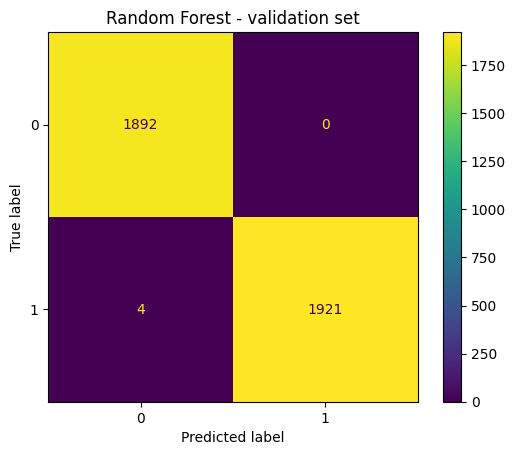

In [114]:

log_cm = confusion_matrix(y_val, y_pred_rf)
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)
log_disp.plot()
plt.title('Random Forest - validation set'); plt.show()

In [120]:

target_labels = ['opinion', 'claim']
classification_report(y_val, y_pred_rf, target_names=target_labels)

'              precision    recall  f1-score   support\n\n     opinion       1.00      1.00      1.00      1892\n       claim       1.00      1.00      1.00      1925\n\n    accuracy                           1.00      3817\n   macro avg       1.00      1.00      1.00      3817\nweighted avg       1.00      1.00      1.00      3817\n'

## Predictions - Gradient Boosting 

In [116]:
y_pred_xg = gb_cv.best_estimator_.predict(X_val_final)

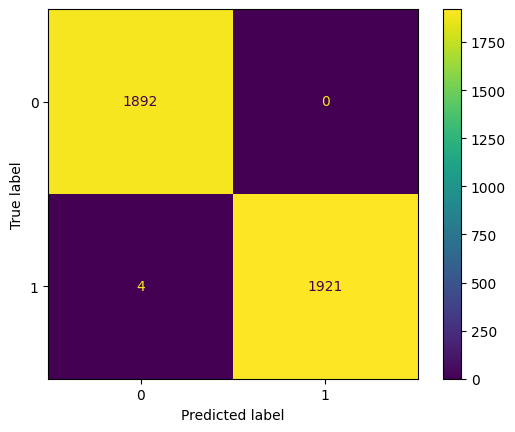

In [117]:

log_cm = confusion_matrix(y_val, y_pred_xg)
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)
log_disp.plot()

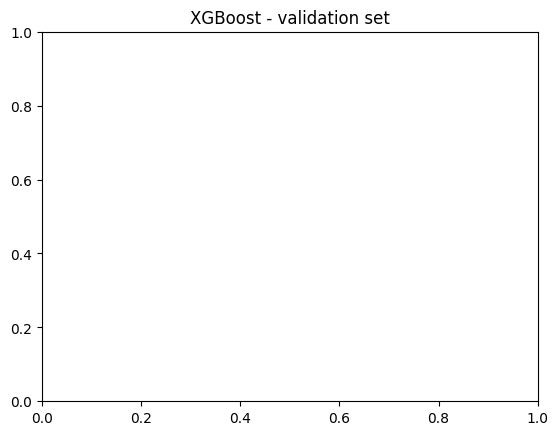

In [118]:
plt.title('XGBoost - validation set'); plt.show()
xg_report = classification_report(y_val, y_pred_xg, target_names=target_labels)

# save models to disk

In [111]:

def save_models():
    # Save the Random Forest model
    joblib.dump(rf_cv.best_estimator_, 'random_forest_model.joblib')

    # Save the Gradient Boosting model
    joblib.dump(gb_cv.best_estimator_, 'gradient_boosting_model.joblib')

    print("Models saved successfully with .joblib extension.")

def load_models():
    # Load the Random Forest model
    rf_model = joblib.load('random_forest_model.joblib')

    # Load the Gradient Boosting model
    gb_model = joblib.load('gradient_boosting_model.joblib')

    print("Models loaded successfully from .joblib files.") 

    return rf_model, gb_model 

save_models() 

Models saved successfully with .joblib extension.


# Final Test Pred

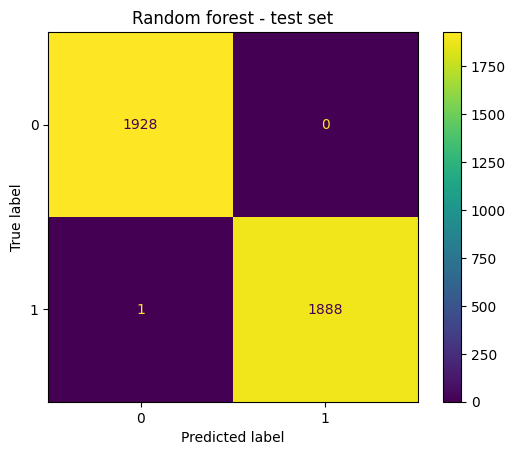

In [109]:
y_pred = rf_cv.best_estimator_.predict(X_test_final)
log_cm = confusion_matrix(y_test, y_pred)
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)
log_disp.plot()
plt.title('Random forest - test set'); plt.show()

# Feature Importance 

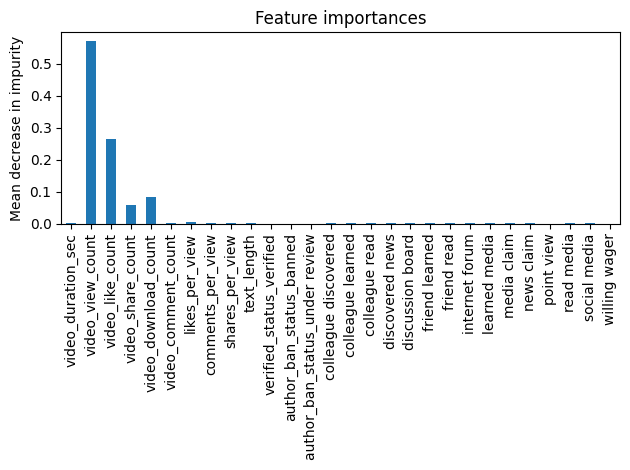

In [110]:
importances = rf_cv.best_estimator_.feature_importances_
rf_importances_sr = pd.Series(importances, index=X_test_final.columns)
fig, ax = plt.subplots()
rf_importances_sr.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()